# Advanced Lane Finding

In [1]:
import os
import os.path
import glob

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lane_finding import *
from lane_finding import utils

# Steps

### 1. Camera Calibration

In [4]:
camera = Camera()

camera.calibrate(images=[Image.read(fpath) for fpath in glob.glob("camera/calibration*.jpg")],
                 pattern_size=(9,6))

# Pipeline Step: Undistort image
def step_undistort_image(image: Image) -> Image:
    return camera.undistort(image)

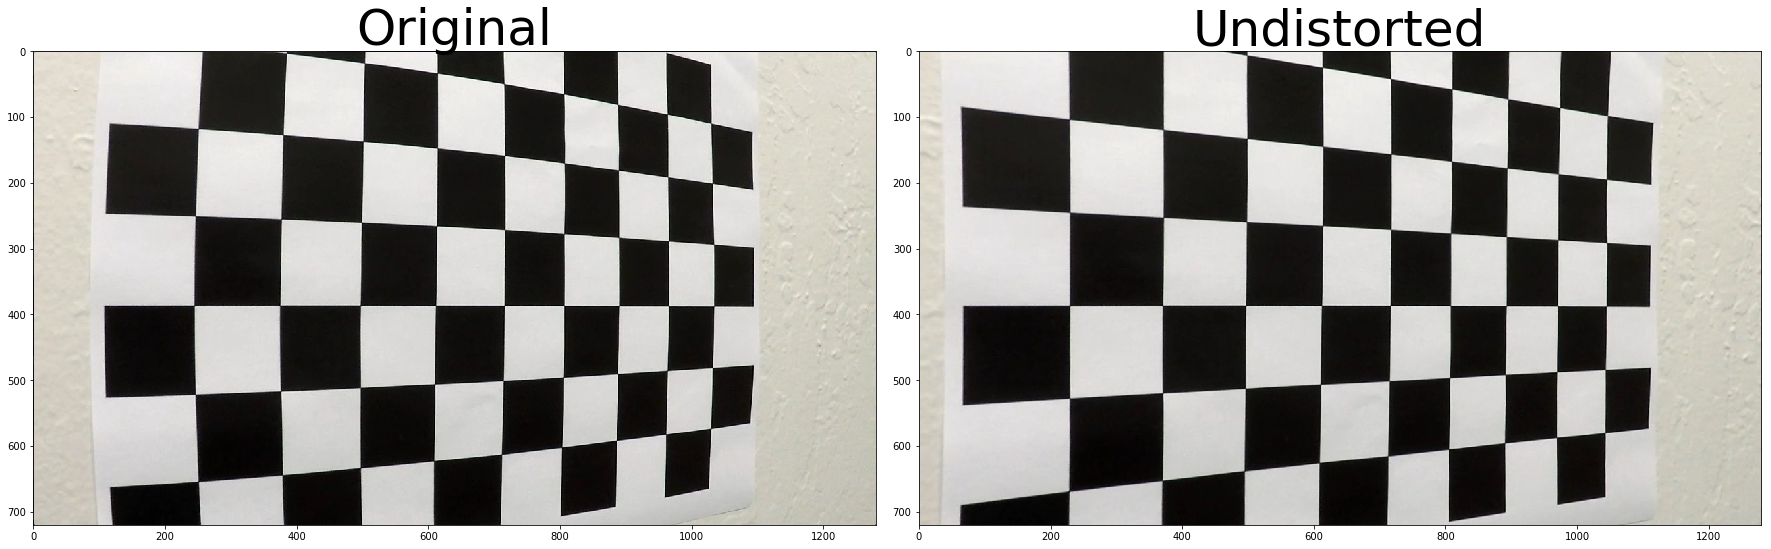

In [5]:
calibration_image = Image.read('camera/calibration5.jpg')
undistorted_image = step_undistort_image(calibration_image)

utils.show_images([
    ("Original", calibration_image),
    ("Undistorted", undistorted_image),
], save_path='output/images/undistorted.jpg')

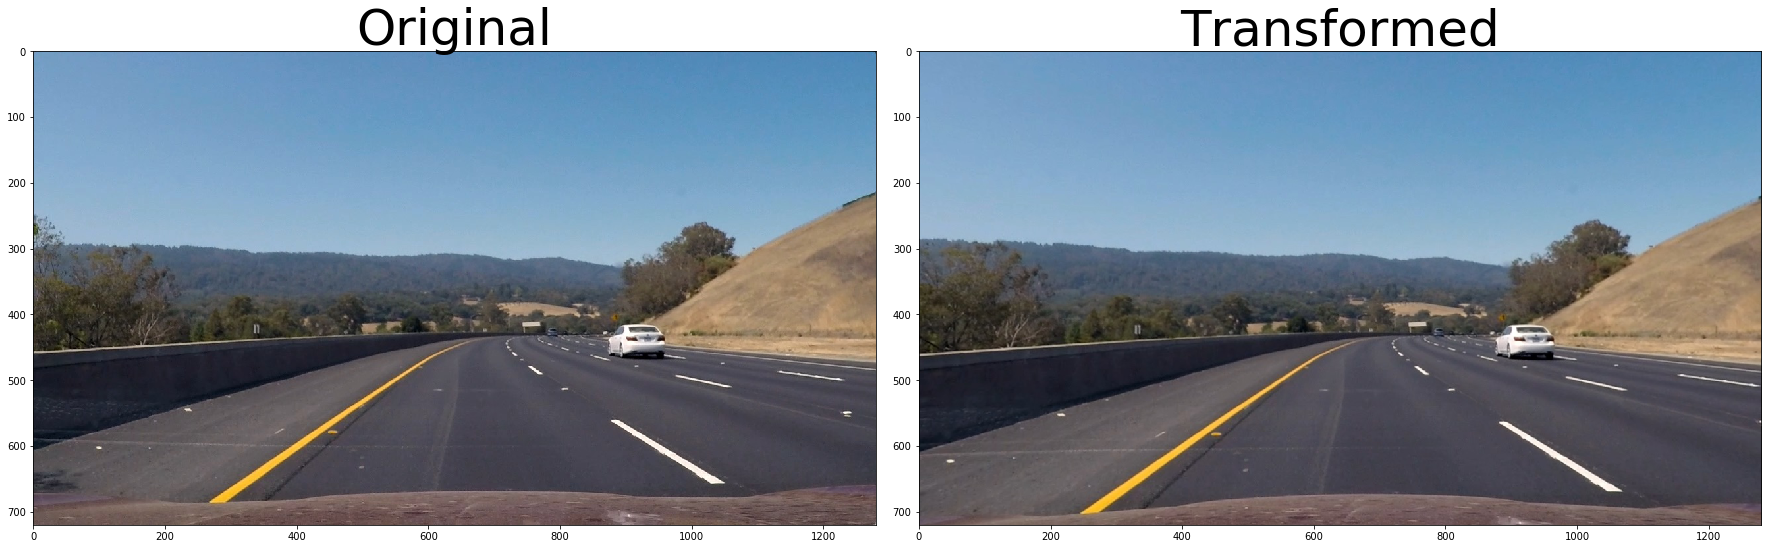

In [6]:
curved_test_image = Image.read('input/images/curved3.jpg')
transformed_image = step_undistort_image(curved_test_image)

utils.show_images([
    ("Original", curved_test_image),
    ("Transformed", transformed_image),
], save_path='output/images/transformed.jpg')

### 2. Color Transforms

In [7]:
# Pipeline Step: Generate binary image to detect lanes
def step_generate_binary_image(image: Image) -> BinaryImage:
    return image.s_channel().binary((170, 255))

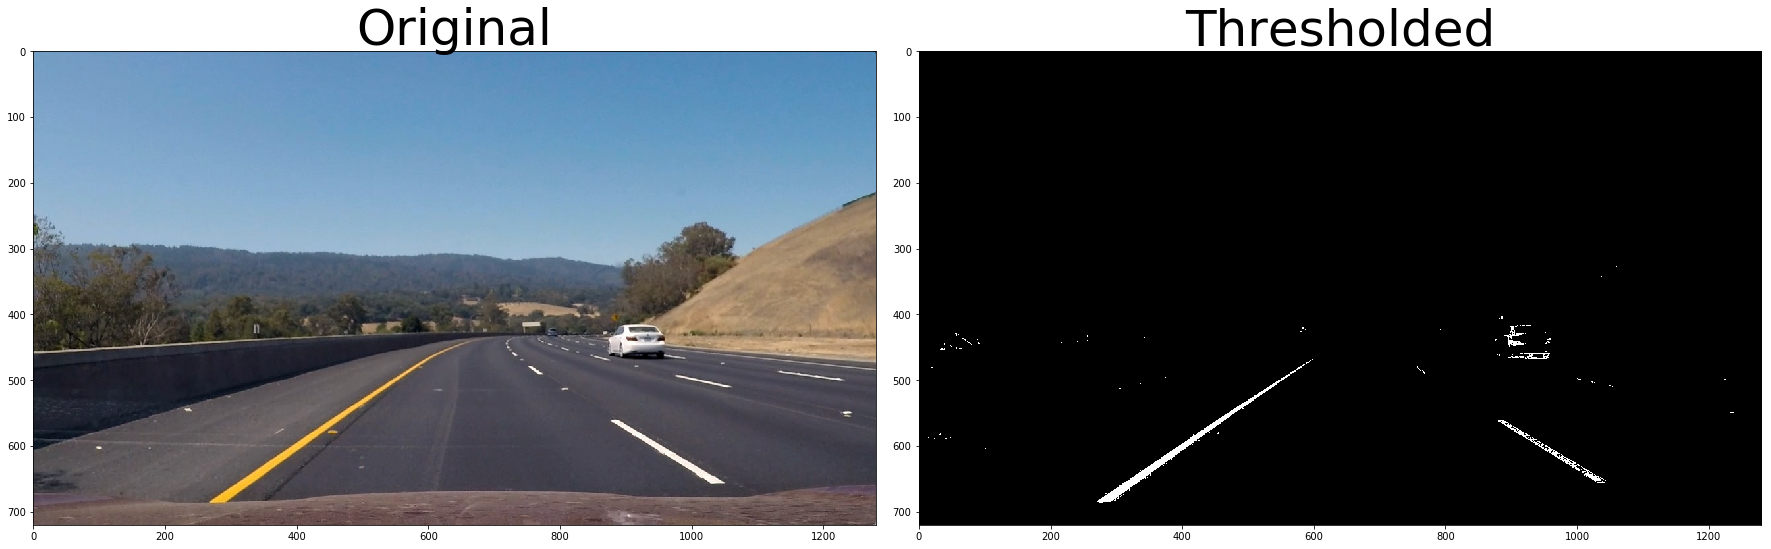

In [8]:
thresholded_image = step_generate_binary_image(curved_test_image)

utils.show_images([
    ("Original", curved_test_image),
    ("Thresholded", thresholded_image),
], save_path='output/images/thresholded.jpg')

### 3. Perspective transform

In [9]:
perspective = Perspective( #FIXME: Inspect image to get better points
    src=[ (200, 700), (600, 450), (700, 450), (1170, 700) ],
    dst=[ (370, 700), (370,   0), (970,   0), ( 970, 700) ])

# Pipeline Step: Apply perspective tranform to binary image
def step_apply_perspective_transform(image: Image) -> Image:
    return perspective.transform(image)

# Pipeline Step: Apply inverse perspective transform to lane overlay
def step_apply_inverse_perspective_transform(image: Image) -> Image:
    return perspective.inverse(image)

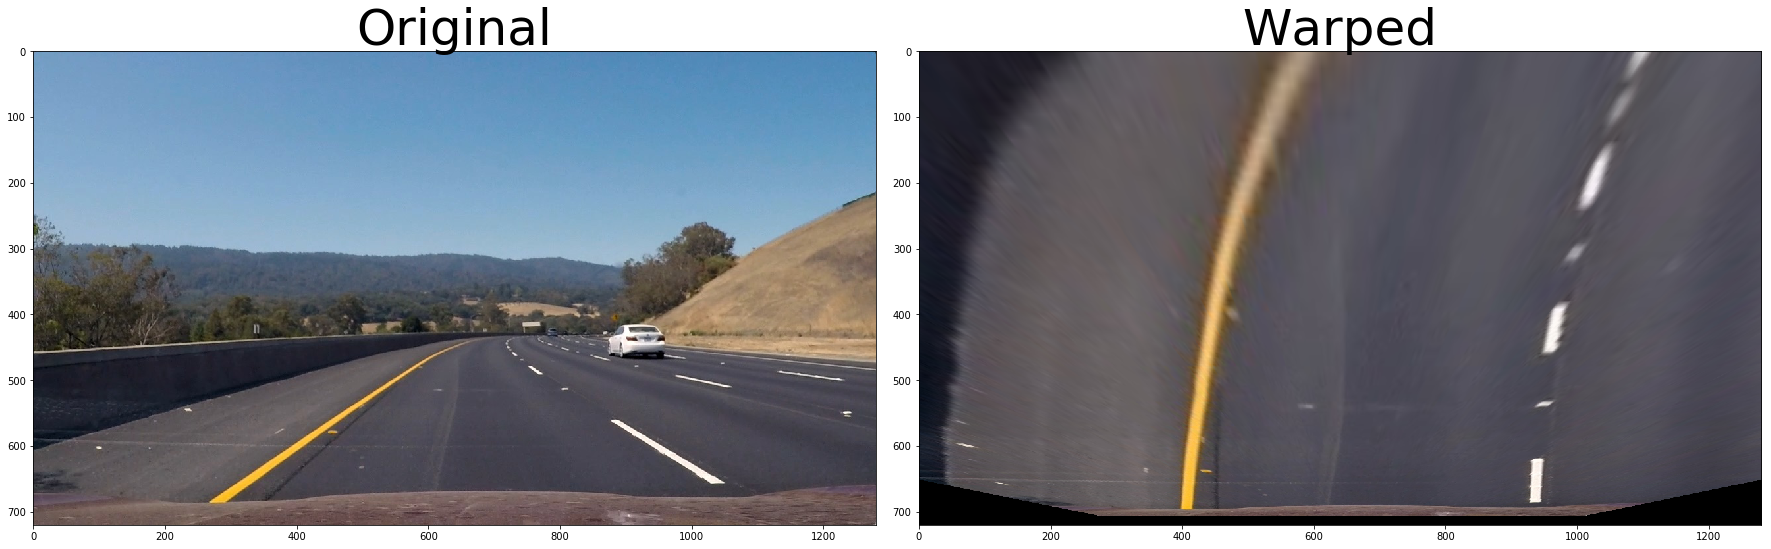

In [10]:
warped_image = step_apply_perspective_transform(curved_test_image)

utils.show_images([
    ("Original", curved_test_image),
    ("Warped", warped_image),
], save_path='output/images/warped.jpg')

# Final result

In [11]:
class Pipeline():

    def __init__(self):
        self._finder = LaneFinder()

    def __call__(self, image: Image) -> Image:
        # Return the last image in the processing pipeline
        return self.processed_images(image)[-1]

    def processed_images(self, image: Image) -> [Image]:
        images = []

        # Undistort input image
        image = step_undistort_image(image)
        images.append(image)

        # Generate binary image from undistorted image
        binary = step_generate_binary_image(image)
        images.append(binary)

        # Apply perspective transform to binary image
        binary = step_apply_perspective_transform(binary)
        images.append(binary)

        # Find lanes in binary image
        lanes, _ = self._finder.search(image=binary)

        # Generate an overlay image with lanes and apply inverse perspective transform
        overlay_lane = self._finder.overlay(image=binary, lanes=lanes)
        overlay_lane = step_apply_inverse_perspective_transform(overlay_lane)
        images.append(overlay_lane)

        # Generate an overlay image with curvature and offset info
        overlay_info = self._finder.overlay_info(image=binary, lanes=lanes)
        images.append(overlay_info)

        # Combine undistorted input image with lane and info overlays
        image = Image.combine(image, 1, overlay_lane, 0.3)
        image = Image.combine(image, 1, overlay_info, 1.0)
        images.append(image)

        return images

### Image processing

In [12]:
# Process image from ./input/images directory and save it to ./output/images
def process_image(fname):

    input_path  = os.path.join(os.curdir, 'input',  'images', fname)
    output_path = os.path.join(os.curdir, 'output', 'images', fname)

    pipeline = Pipeline()

    image = Image.read(input_path)

    output = pipeline(image)

    utils.show_images([
        ("", output),
    ], save_path=output_path)

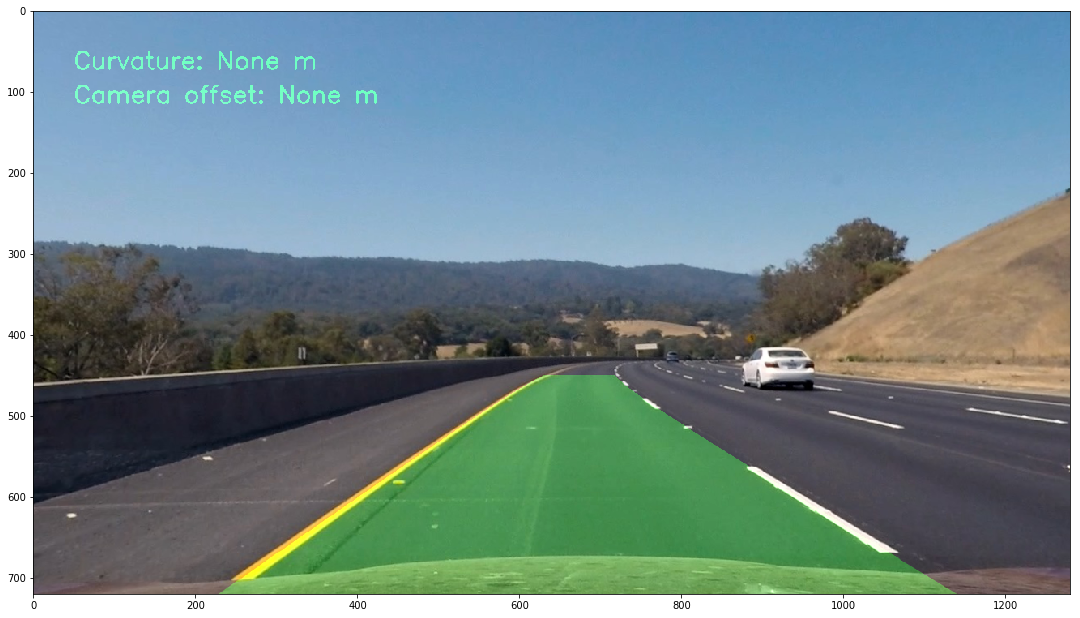

In [13]:
process_image('curved3.jpg')

### Video processing

In [14]:
# Process video from ./input/videos directory and save it to ./output/videos
# If write_gif is True, save a GIF version to ./output/videos
def process_video(fname, subclip_end=None, write_gif=False):

    input_path  = os.path.join(os.curdir, 'input',  'videos', fname)
    output_path = os.path.join(os.curdir, 'output', 'videos', fname)

    pipeline = Pipeline()

    clip = Video.read(input_path)

    if subclip_end is not None:
        clip = clip.subclip(end=subclip_end)

    clip = clip.process(pipeline)

    clip.write(output_path)
    
    if write_gif:
        gif_path = os.path.splitext(output_path)[0] + '.gif'
        clip.write_gif(gif_path)

    return utils.show_video(output_path)

In [15]:
process_video('project.mp4', subclip_end=3, write_gif=True)

[MoviePy] >>>> Building video ./output/videos/project.mp4
[MoviePy] Writing video ./output/videos/project.mp4


 99%|█████████▊| 75/76 [01:10<00:00,  1.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/videos/project.mp4 


[MoviePy] Building file ./output/videos/project.gif with imageio


 99%|█████████▊| 75/76 [01:30<00:01,  1.21s/it]


In [16]:
utils.show_video('./input/videos/challenge.mp4')
# process_video('challenge.mp4')

In [17]:
utils.show_video('./input/videos/harder_challenge.mp4')
# process_video('harder_challenge.mp4')